# LIBRARIES

In [18]:
import os
import cv2
import numpy as np
import hashlib
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Path to dataset

In [6]:
!unzip "/content/dataset(lungs).zip"

Archive:  /content/dataset(lungs).zip
replace Data/test/adenocarcinoma/000108 (3).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/test/adenocarcinoma/000109 (2).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/test/adenocarcinoma/000109 (4).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/test/adenocarcinoma/000109 (5).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Data/test/adenocarcinoma/000109 (5).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
data_dir = "/content/Data"

In [8]:
train_dir = "/content/Data/train"
test_dir = "/content/Data/test"
valid_dir = "/content/Data/valid"

# Image Preprocessing Parameters

In [9]:
IMAGE_SIZE = (224, 224)
NORMALIZE = True
AUGMENTATION = True

# Allowed Image Formats

In [10]:
IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg"}

# Data Augmentation Pipeline

In [11]:
augment = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2)
]) if AUGMENTATION else None

In [12]:
def compute_hash(image_path):
    """Compute hash of an image to find duplicates."""
    try:
        with open(image_path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()
    except IsADirectoryError:
        print(f"Skipping directory: {image_path}")
        return None

In [13]:
def preprocess_image(image_path):
    """Load, resize, and normalize image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None  # Skip corrupt images
    img = cv2.resize(img, IMAGE_SIZE)
    if NORMALIZE:
        img = img / 255.0  # Normalize pixel values
    return img

In [14]:
def extract_features(image):
    """Extract HOG features from the image."""
    features, _ = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                      visualize=True)
    return features

In [51]:
from skimage.feature import graycomatrix, graycoprops

def extract_texture_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, correlation]


In [52]:
from skimage.measure import regionprops
from skimage.filters import sobel

def extract_shape_features(image):
    edges = sobel(image)
    regions = regionprops(edges.astype(int))
    return [regions[0].eccentricity, regions[0].solidity] if regions else [0, 0]


In [16]:
def load_data():
    X, y = [], []
    hashes = {}

    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue  # Skip non-directory files

        for root, _, files in os.walk(category_path):
            for img_file in files:
                img_path = os.path.join(root, img_file)

                if not any(img_file.lower().endswith(ext) for ext in IMAGE_EXTENSIONS):
                    print(f"Skipping non-image file: {img_path}")
                    continue

                print(f"Processing image: {img_path}")  # Debugging

                img_hash = compute_hash(img_path)
                if img_hash is None or img_hash in hashes:
                    continue
                hashes[img_hash] = img_path

                image = preprocess_image(img_path)
                if image is None:
                    continue

                X.append(extract_features(image))
                y.append(category)

    if not X:
        raise ValueError("No images were found or processed. Check dataset path and image formats.")

    return np.array(X), np.array(y)


In [17]:
try:
    X, y = load_data()
    print(f"Total images processed: {len(X)}")
except ValueError as e:
    print(f"Error: {e}")


Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000120 (6).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000065 (5).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000041 (4).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000106 (7).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/sq1.png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000024 (7).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000029 (4).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000046 (5).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000028 (7).png
Processing image: /content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/00

# Load data

# Ensure `X` is in the correct shape

In [19]:
X = np.array(X)
if X.ndim == 1:
    X = X.reshape(len(X), -1)  # Ensure 2D shape for SMOTE

print(f"Shape of X before SMOTE: {X.shape}")

Shape of X before SMOTE: (847, 6084)



# Handle Imbalanced Data using SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Resampled X shape: {X_resampled.shape}")

Resampled X shape: (1548, 6084)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 1238, Test set size: 310


# Train an ML Model

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = SVC(kernel="linear", random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9839
              precision    recall  f1-score   support

        test       1.00      1.00      1.00       106
       train       1.00      0.95      0.98       104
       valid       0.95      1.00      0.98       100

    accuracy                           0.98       310
   macro avg       0.98      0.98      0.98       310
weighted avg       0.98      0.98      0.98       310



In [48]:
model = SVC(kernel="linear", class_weight="balanced", random_state=42)

In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={0: 500, 1: 500, 2: 1000}, random_state=42)  # Adjusted ratios
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

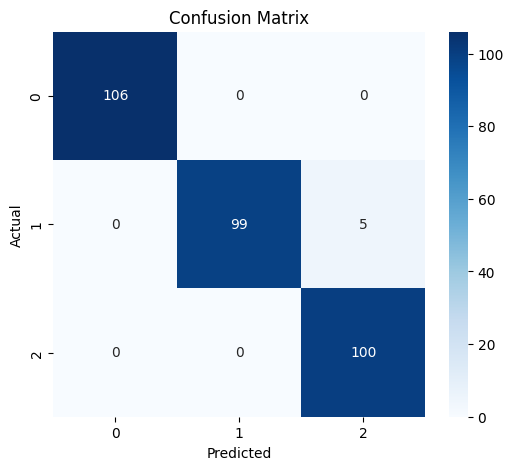

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Normal', 'Benign', 'Malignant']))


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       106
      Benign       1.00      0.95      0.98       104
   Malignant       0.95      1.00      0.98       100

    accuracy                           0.98       310
   macro avg       0.98      0.98      0.98       310
weighted avg       0.98      0.98      0.98       310



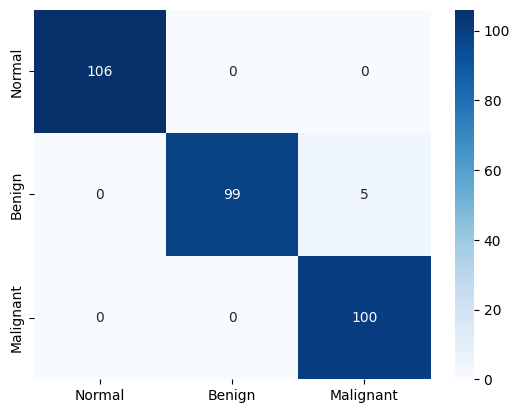

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.show()

# XGBoost (Extreme Gradient Boosting)

In [24]:
from sklearn.preprocessing import LabelEncoder

# Ensure labels are converted to numeric values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert string labels to numbers
y_test = label_encoder.transform(y_test)  # Transform test labels

# Check the mapping
print(f"Class Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Class Mapping: {np.str_('test'): np.int64(0), np.str_('train'): np.int64(1), np.str_('valid'): np.int64(2)}


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")


XGBoost Accuracy: 0.9645


# Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

# Train model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

Random Forest Accuracy: 0.9677


In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load preprocessed training data
# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize base models
svm = SVC(kernel="linear", probability=False, random_state=42)  # No probability for hard voting
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the Hard Voting Classifier
hard_voting_clf = VotingClassifier(
    estimators=[('svm', svm), ('xgb', xgb), ('rf', rf)],
    voting='hard'  # Majority voting
)

# Train the ensemble model
hard_voting_clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(hard_voting_clf, "lung_cancer_hard_voting.pkl")

# Predict on test data
y_pred = hard_voting_clf.predict(X_test)

# Evaluate performance
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:50:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9741935483870968
📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       106
           1       0.96      0.96      0.96       104
           2       0.96      0.99      0.98       100

    accuracy                           0.97       310
   macro avg       0.97      0.97      0.97       310
weighted avg       0.97      0.97      0.97       310



#  Save the XGBoost Model

In [58]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit encoder on training labels
y_train_encoded = encoder.fit_transform(y_train)

# Initialize base models
svm = SVC(kernel="linear", probability=False, random_state=42)  # No probability for hard voting
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the Hard Voting Classifier
hard_voting_clf = VotingClassifier(
    estimators=[("svm", svm), ("xgb", xgb), ("rf", rf)],
    voting="hard"  # Majority voting
)

# Train the ensemble model
hard_voting_clf.fit(X_train, y_train_encoded)

# Save the trained model
joblib.dump(hard_voting_clf, "lung_cancer_hard_voting.pkl")

# Save the label encoder
joblib.dump(encoder, "label_encoder.pkl")

print("✅ Hard Voting Model and Label Encoder saved successfully!")

# Test the saved model (optional)
y_test_encoded = encoder.transform(y_test)
y_pred = hard_voting_clf.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print("📊 Classification Report:\n", classification_report(y_test_encoded, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Hard Voting Model and Label Encoder saved successfully!
✅ Accuracy: 0.9742
📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       106
           1       0.96      0.96      0.96       104
           2       0.96      0.99      0.98       100

    accuracy                           0.97       310
   macro avg       0.97      0.97      0.97       310
weighted avg       0.97      0.97      0.97       310



In [59]:
import joblib
import numpy as np

# Load the trained Hard Voting Classifier model and label encoder
voting_model = joblib.load("lung_cancer_hard_voting.pkl")
encoder = joblib.load("label_encoder.pkl")

# Ensure y_test is encoded
y_test_encoded = encoder.transform(y_test)

# Predict on test data
y_pred_encoded = voting_model.predict(X_test)

# Convert numeric predictions back to class labels
y_pred_labels = encoder.inverse_transform(y_pred_encoded)

# Convert actual test labels back to original class labels
y_test_labels = encoder.inverse_transform(y_test_encoded)

# Print results
print("🔹 Actual Labels:", y_test_labels[:10])  # First 10 actual labels
print("🔹 Predicted Labels:", y_pred_labels[:10])  # First 10 predicted labels


🔹 Actual Labels: [1 2 2 2 2 1 1 0 0 0]
🔹 Predicted Labels: [2 2 2 2 2 2 1 0 0 0]


In [60]:
print("Actual Labels:", y_test[:10])  # First 10 actual labels
print("Predicted Labels:", y_pred[:10])  # First 10 predicted labels

Actual Labels: [1 2 2 2 2 1 1 0 0 0]
Predicted Labels: [2 2 2 2 2 2 1 0 0 0]


In [61]:
import joblib
import numpy as np

# Load the trained SVM model and label encoder
svm_model = joblib.load("lung_cancer_svm.pkl")  # Fixed model name
encoder = joblib.load("label_encoder.pkl")

# Select a sample from X_test (assuming X_test is a NumPy array)
sample_input = X_test[0].reshape(1, -1)  # Ensure it's in the correct shape for prediction

# Predict on the sample
predicted_class = svm_model.predict(sample_input)  # Use svm_model instead of xgb_model

# Convert numeric prediction back to class label
predicted_label = encoder.inverse_transform([predicted_class[0]])

print("Predicted Class:", predicted_label[0])

Predicted Class: 2
